# Python+numpy构建波士顿房价预测模型

# 一、任务描述

本次任务主要是“波士顿房价预测”，众所周知，房价的影响因素有很多，并且每个影响因素对于房价的影响程度不尽相同，而本次任务所使用的数据集是波士顿地区的房价及其13个影响因素，目的是使用回归算法来拟合出一个房价预测模型。

# 二、数据说明

本任务所使用的数据集包含13个特征变量，分别是：
- CRIM: 城镇人均犯罪率
- ZN: 住宅用地所占比例
- INDUS: 城镇中非住宅用地所占比例
- CHAS: 虚拟变量,用于回归分析
- NOX: 环保指数
- RM: 每栋住宅的房间数
- AGE: 1940 年以前建成的自住单位的比例
- DIS: 距离 5 个波士顿的就业中心的加权距离
- RAD: 距离高速公路的便利指数
- TAX: 每一万美元的不动产税率
- PTRATIO: 城镇中的教师学生比例
- B: 城镇中的黑人比例
- LSTAT: 地区中有多少房东属于低收入人群
- MEDV: 自住房屋房价中位数（也就是均价）

## 2.1 读取数据

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
data_path = './housing.data'
data = np.fromfile(data_path,sep=' ')
print(data.shape)

(7084,)


- 可以看到，我们得到了一个大小为[7084*1]的矩阵，其中的内容是第0-13项数据为第一条数据，一条数据中包含0-12项一共13个特征值，第14项为真实的目标，我们的任务就是利用前面13项的数据来构建回归模型，是得得到的输出尽可能的与真实数据接近。

## 2.2 数据预处理

### 2.2.1 数据格式转化

- 由于读入的数据是一维数据，我们需要将其转化为我们可以使用的[x*14]维的矩阵形式。每行为一个数据样本（14个值），每个数据样本包含13个影响房价的特征和一个该类型房屋的均价。

In [3]:
feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
feature_num = len(feature_names)
data = data.reshape([data.shape[0] // feature_num, feature_num])
print(data.shape)

(506, 14)


In [4]:
# 查看部分数据
x = data[0]
print(x)

[6.320e-03 1.800e+01 2.310e+00 0.000e+00 5.380e-01 6.575e+00 6.520e+01
 4.090e+00 1.000e+00 2.960e+02 1.530e+01 3.969e+02 4.980e+00 2.400e+01]


### 2.2.2 数据归一化

- 可以看到，最终我们得到了一个[506*14]维的矩阵，输出其中一行数据，我们发现，数据之间的大小差距很大，可以看到第一个数据和第三个数据差了3个数量级，而这会导致得到的模型主要有数值比较大的特征所影响，因此，对数据进行归一化是十分必要的。

In [7]:
# 计算训练集的最大值，最小值，平均值
maximums, minimums, avgs = data.max(axis=0),data.min(axis=0),data.sum(axis=0) / data.shape[0]
for i in range(feature_num):
    data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

### 2.2.3 数据集划分

- 数据仅是我们得到的数据，为了评估模型的好坏，我们不能使用已经参与训练模型的数据。因此，我们首先需要将数据集进行划分，分为训练集和测试集两部分，且这两部分数据集最好没有重复数据，且随即划分，两者之间没有明显的差异。

In [8]:
# 数据集划分
ratio = 0.8
offset = int(data.shape[0] * ratio)
training_data = data[:offset]
print(training_data.shape)

(404, 14)


## 2.3 函数封装

In [ ]:
def load_data():
    datafile = './housing.data'
    data = np.fromfile(datafile, sep=' ')
    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)
    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])
    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]
    # 计算训练集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), training_data.sum(axis=0) / training_data.shape[0]
    # 对数据进行归一化处理
    for i in range(feature_num):
        data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])
    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

# 三、模型设计

# 3.1 定义激活函数

- 一个神经网络若是没有激活函数，则无论网络的结构多么复杂，其最终得到的始终是一个线性模型，而线性模型针对“异或”问题这类线性不可分的问题时是无法找到一个合适的解的，为了可以求解非线性问题，引入了激活函数，这样可以增加非线性因素，提高模型的拟合能力。

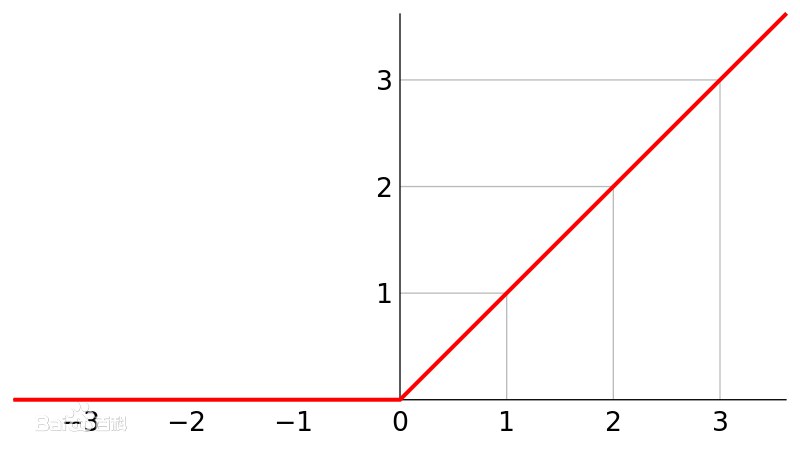

# 3.2 定义损失函数

- 模型设计完成后，需要通过训练来调整其中的参数，而调整的依据就是通过损失函数来反映的，所谓损失函数定义为模型的输出和真实值之间的差距，对损失函数进行求导，可以对后续的参数修正起到作用。

- 本任务使用的损失函数为均方误差
$$Loss= \frac{1}{N}\sum_{i=1}^N{(y_i - z_i)^2}$$

## 3.3 Python+numpy定义网络

### 3.3.1 单层网络

In [11]:
class Network(object):
    def __init__(self, num_of_weights):
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        cost = error * error
        cost = np.mean(cost)
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)
        return gradient_w, gradient_b
    
    def update(self, gradient_w, gradient_b, eta = 0.01):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b
        
    def train(self, x, y, iterations=100, eta=0.01):
        losses = []
        for i in range(iterations):
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w, gradient_b = self.gradient(x, y)
            self.update(gradient_w, gradient_b, eta)
            losses.append(L)
        return losses

(404, 14)

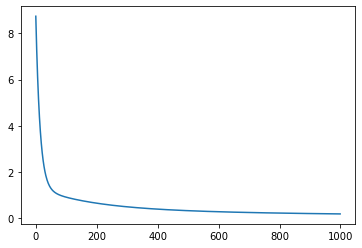

In [32]:
# 获取数据
train_data, test_data = load_data()
x = train_data[:, :-1]
y = train_data[:, -1:]
# 创建网络
net = Network(13)
num_iterations=1000
# 启动训练
losses = net.train(x,y, iterations=num_iterations, eta=0.01)

# 画出损失函数的变化趋势
plot_x = np.arange(num_iterations)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

### 3.3.2 双层网络

- 双层神经网络中含有一个隐含层，这里我假定其中的隐含层包含10个节点，下面给出损失函数对各权重和偏置的求导规则。

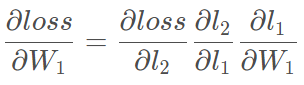

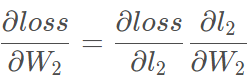

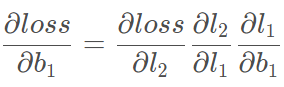

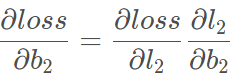

In [28]:
# 两层神经网络
class Network2(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，
        # 此处设置固定的随机数种子
        np.random.seed(0)
        self.w1 = np.random.randn(num_of_weights, 10)
        self.w2 = np.random.randn(10,1)
        self.b1 = 0.
        self.b2 = 0.
        
    def forward(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        z2 = np.maximum(z1,0)  # Relu
        z = np.dot(z2, self.w2) + self.b2
        return z
    
    def loss(self, z, y):
        error = z - y
        cost = error * error
        cost = np.mean(cost)
        return cost
    
    def gradient(self, x, y):
        z1 = np.dot(x, self.w1) + self.b1
        z2 = np.maximum(z1,0)
        z = np.dot(z2, self.w2) + self.b2
        y_grad = 2*(z-y)
        gradient_w2 = z2.T.dot(y_grad)
        relu_grad=y_grad.dot(self.w2.T)
        h_grad=relu_grad.copy()
        h_grad[z1<0]=0
        gradient_w1=x.T.dot(h_grad)
        gradient_b2 = np.mean(2*(z-y)/len(y))
        gradient_b1 = np.mean(np.dot(2*(z-y)/len(y),self.w2.T),axis=0)
        return gradient_w1,gradient_w2,gradient_b1,gradient_b2
    
    def update(self, gradient_w1,gradient_w2,gradient_b1,gradient_b2, eta = 0.01):
        self.w1 = self.w1 - eta * gradient_w1
        self.w2 = self.w2 - eta * gradient_w2
        self.b1 = self.b1 - eta * gradient_b1
        self.b2 = self.b2 - eta * gradient_b2
        
    def train(self, x, y, iterations=100, eta=0.01):
        losses = []
        for i in range(iterations):
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w1,gradient_w2,gradient_b1,gradient_b2 = self.gradient(x, y)
            self.update(gradient_w1,gradient_w2,gradient_b1,gradient_b2, eta)
            losses.append(L)
        return losses

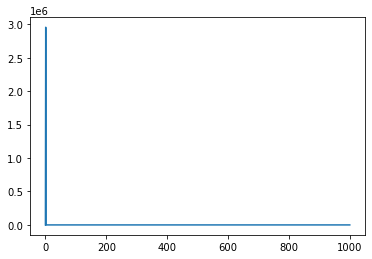

In [29]:
# 获取数据
train_data, test_data = load_data()
x = train_data[:, :-1]
y = train_data[:, -1:]
# 创建网络
net = Network2(13)
num_iterations=1000
# 启动训练
losses = net.train(x,y, iterations=num_iterations, eta=0.01)

# 画出损失函数的变化趋势
plot_x = np.arange(num_iterations)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

- 由上述损失函数的变化曲线可以得到，单层神经网络的表达能力不如双层神经网络，且单层神经网络中由于没有激活函数的存在，所以最终得到的模型损失较大，而双层神经网络中加入了激活函数，可以看到，其可以得到比较完美的模型。